# Training a segmentation model

In [1]:
#Preparing data
import os
import nibabel as nib
import pandas as pd
from os.path import join
import numpy as np
from skimage.io import imread
import SimpleITK as sitk
import matplotlib.pyplot as plt
from shutil import copyfile
from nnunet.utils import generate_dataset_json



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



## preprocessing

In [2]:
def load_tiff_convert_to_nifti(img_file, lab_file, img_out_base, anno_out, spacing):
    img = imread(img_file)
    img_itk = sitk.GetImageFromArray(img.astype(np.float32))
    img_itk.SetSpacing(np.array(spacing)[::-1])
    sitk.WriteImage(img_itk, join(img_out_base + "_0000.nii.gz"))

    if lab_file is not None:
        l = imread(lab_file)
        l = (l / 255).astype(int) # set label to 0 or 1
        l[l > 0] = 1
        l_itk = sitk.GetImageFromArray(l.astype(np.uint8))
        l_itk.SetSpacing(np.array(spacing)[::-1])
        sitk.WriteImage(l_itk, join(anno_out+'.nii.gz'))

In [3]:
idx = 'M1_2'
postfix = '_C0.tif'
base_name = 'KAKU4-wt--CRWN1-wt--CRWN4-wt_Cot_J13_STD_FIXE_H258_{}'.format(idx)

img_folder = 'images_sophie'
img_file = img_folder+base_name+postfix

msk_folder = 'masks_sophie'
msk_file = msk_folder+base_name+postfix

img_out_base_folder = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTr/'
img_test_out_base_folder = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/'
img_out_base = img_out_base_folder+base_name

anno_out_folder = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/labelsTr/'
anno_test_out_folder = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/labelsTs/'
anno_out = anno_out_folder+base_name

case = 'Nucleus'

target_base = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus'

spacing=(0.2e-3, 0.1032e-3,0.1032e-3)

In [4]:
def add_zeros_before(i):
    # converts i to '00i'
    if i < 10:
        return '00{}'.format(i)
    elif i < 100:
        return '0{}'.format(i)
    else:
        return '{}'.format(i)

In [5]:
# converts all images to nifti format
import tqdm
list_imgs = os.listdir(img_folder)
for i in range(len(list_imgs)):
#     img = imread(img_folder + list_imgs[i])
#     msk = imread(msk_folder + list_imgs[i])
    
    # input name
    base_name = list_imgs[i][:str.rfind(list_imgs[i], '.')]
    
    img_out_base = img_out_base_folder+case+'_'+add_zeros_before(i)
    anno_out = anno_out_folder+case+'_'+add_zeros_before(i)
    
    
    load_tiff_convert_to_nifti(
        img_folder + '/' + list_imgs[i], 
        msk_folder + '/' + list_imgs[i], 
        img_out_base, 
        anno_out, 
        spacing)

# plt.subplot(1,2,1)
# plt.imshow(img[len(img)//2])

# plt.subplot(1,2,2)
# plt.imshow(msk[len(msk)//2])

In [6]:
# move test images to the right folder

#'fold_x' à la place de 'hold_out'
def get_train_test_df(df):
    """
    Return the train set and the test set
    """
    train_set = np.array(df4[df4['fold_x']==0].iloc[:,0])
    test_set = np.array(df4[df4['fold_x']==1].iloc[:,0])
    return train_set, test_set

df_path = '/home/mougeotg/all/data/nuclei/gred_val_all/'
df4 = pd.read_csv('folds_x_sophie.csv')

In [7]:
train_set, test_set = get_train_test_df(df4)
print("Size of train set {}".format(len(train_set)))
print("Size of test set {}".format(len(test_set)))

Size of train set 18
Size of test set 18


In [8]:
# copy test files to test folder
# removes them from the train folder
list_imgs = os.listdir(img_folder)
for i in range(len(list_imgs)):
    base_name = list_imgs[i]
    if base_name in test_set:
        img_out_base = case+'_'+add_zeros_before(i)+'_0000.nii.gz'
        if os.path.exists(img_out_base_folder+img_out_base):
            copyfile(img_out_base_folder+img_out_base, img_test_out_base_folder+img_out_base)
            os.remove(img_out_base_folder+img_out_base)
            
        anno_out_base = case+'_'+add_zeros_before(i)+'.nii.gz'
        if os.path.exists(anno_out_folder+anno_out_base):
            copyfile(anno_out_folder+anno_out_base, anno_test_out_folder+anno_out_base)
            os.remove(anno_out_folder+anno_out_base)
            
        

# for i in range(len(test_set)):
#     base_name = list_imgs[i][:str.rfind(test_set[i], '.')]
#     img_name = base_name + 
#     copyfile(img_out_base_folder+test_set[i], img_test_out_base_folder+test_set[i])
#     os.remove(img_out_base_folder+test_set[i])

In [9]:
# dataset.json generator
generate_dataset_json(
    join(target_base,'dataset.json'),
    img_out_base_folder,
    img_test_out_base_folder,
    modalities=('D'),
    labels = {0: 'background', 1: 'nucleus'},
    dataset_name=case,
    license='MIT'
)

In [10]:
#pre processing
os.system('nnUNet_plan_and_preprocess -t 500 --verify_dataset_integrity')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case Nucleus_000
checking case Nucleus_002
checking case Nucleus_003
checking case Nucleus_004
checking case Nucleus_005
checking case Nucleus_006
checking case Nucleus_008
checking case Nucleus_009
checking case Nucleus_010
checking case Nucleus_011
checking case Nucleus_013
checking case Nucleus_014
checking case Nucleus_015
checking case Nucleus_016
checking case Nucleus_017
checking case Nucleus_018
checking case Nucleus_019
checking case Nucleus_020
checking case Nucleus_021
checking case Nucleus_023
checking case Nucleus_024
checking case Nucleus_025
checking case Nucleus_027
checking case Nuc

no resampling necessary
no resampling necessary
before: {'spacing': array([0.0002   , 0.0001032, 0.0001032]), 'spacing_transposed': array([0.0002   , 0.0001032, 0.0001032]), 'data.shape (data is transposed)': (1, 60, 195, 139)} 
after:  {'spacing': array([0.0002   , 0.0001032, 0.0001032]), 'data.shape (data is resampled)': (1, 60, 195, 139)} 

normalization...
normalization done
1 10000
saving:  nnUNet_preprocessed/Task500_Nucleus/nnUNetData_plans_v2.1_2D_stage0/Nucleus_004.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([0.0002   , 0.0001032, 0.0001032]), 'spacing_transposed': array([0.0002   , 0.0001032, 0.0001032]), 'data.shape (data is transposed)': (1, 55, 133, 122)} 
after:  {'spacing': array([0.0002   , 0.0001032, 0.0001032]), 'data.shape (data is resampled)': (1, 55, 133, 122)} 

normalization...
normalization done
1 10000
saving:  nnUNet_preprocessed/Task500_Nucleus/nnUNetData_plans_v2.1_2D_stage0/Nucleus_005.npz
no resampling necessary
no resampl

0

## Training

#os.system('rm -f nnUNet_preprocessed/Task500_Nucleus/nnUNetData_plans_v2.1_stage0/*.npy')

In [11]:
os.system('nnUNet_train 3d_fullres nnUNetTrainer_Experimental Task500_Nucleus 0 --npz')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainer_Experimental'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'D'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 3, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 128]), 'median_patient_size_in_voxels': array([ 57, 120, 124]),

)
2022-05-04 08:36:44.411366: 

2022-05-04 08:36:44.411605: 
epoch:  0
2022-05-04 08:41:15.829717: train loss : -0.7101
2022-05-04 08:41:29.676172: validation loss: -0.8464
2022-05-04 08:41:29.676583: Average global foreground Dice: [0.8751]
2022-05-04 08:41:29.676675: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 08:41:30.182676: lr: 0.008181
2022-05-04 08:41:30.182842: This epoch took 285.771176 s

2022-05-04 08:41:30.182888: 
epoch:  1
2022-05-04 08:45:54.537894: train loss : -0.8444
2022-05-04 08:46:08.209585: validation loss: -0.8700
2022-05-04 08:46:08.210010: Average global foreground Dice: [0.9065]
2022-05-04 08:46:08.210086: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 08:46:08.778325: lr: 0.006314
2022-05-04 08:46:08.833762: saving checkpoint...
2022-05-04 08:46:09.092331: done, saving took 0.31 seconds
2022-05-04 08:46:09.100991: This epoch took 278.918061 s

2022-0

0

In [12]:
os.system('nnUNet_train 3d_fullres nnUNetTrainer_Experimental Task500_Nucleus 1 --npz')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainer_Experimental'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'D'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 3, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 128]), 'median_patient_size_in_voxels': array([ 57, 120, 124]),

)
2022-05-04 09:00:42.957620: 

2022-05-04 09:00:42.989294: 
epoch:  0
2022-05-04 09:05:19.937615: train loss : -0.7373
2022-05-04 09:05:33.639657: validation loss: -0.8587
2022-05-04 09:05:33.640109: Average global foreground Dice: [0.8886]
2022-05-04 09:05:33.640195: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 09:05:34.109504: lr: 0.008181
2022-05-04 09:05:34.109661: This epoch took 291.120167 s

2022-05-04 09:05:34.109705: 
epoch:  1
2022-05-04 09:09:57.026617: train loss : -0.8521
2022-05-04 09:10:10.662554: validation loss: -0.8672
2022-05-04 09:10:10.662943: Average global foreground Dice: [0.895]
2022-05-04 09:10:10.663014: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 09:10:11.236233: lr: 0.006314
2022-05-04 09:10:11.288464: saving checkpoint...
2022-05-04 09:10:11.542713: done, saving took 0.31 seconds
2022-05-04 09:10:11.550855: This epoch took 277.441110 s

2022-05

0

In [13]:
os.system('nnUNet_train 3d_fullres nnUNetTrainer_Experimental Task500_Nucleus 2 --npz')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainer_Experimental'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'D'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 3, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 128]), 'median_patient_size_in_voxels': array([ 57, 120, 124]),

)
2022-05-04 09:25:00.316898: 

2022-05-04 09:25:00.317078: 
epoch:  0
2022-05-04 09:29:46.039078: train loss : -0.7263
2022-05-04 09:29:59.730018: validation loss: -0.8410
2022-05-04 09:29:59.730495: Average global foreground Dice: [0.8942]
2022-05-04 09:29:59.730591: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 09:30:00.279722: lr: 0.008181
2022-05-04 09:30:00.279895: This epoch took 299.962749 s

2022-05-04 09:30:00.279945: 
epoch:  1
2022-05-04 09:34:23.633499: train loss : -0.8609
2022-05-04 09:34:37.294675: validation loss: -0.8638
2022-05-04 09:34:37.295053: Average global foreground Dice: [0.9025]
2022-05-04 09:34:37.295118: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 09:34:37.884192: lr: 0.006314
2022-05-04 09:34:37.938443: saving checkpoint...
2022-05-04 09:34:38.194978: done, saving took 0.31 seconds
2022-05-04 09:34:38.201412: This epoch took 277.921424 s

2022-0

0

In [14]:
os.system('nnUNet_train 3d_fullres nnUNetTrainer_Experimental Task500_Nucleus 3 --npz')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainer_Experimental'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'D'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 3, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 128]), 'median_patient_size_in_voxels': array([ 57, 120, 124]),

)
2022-05-04 09:49:13.450926: 

2022-05-04 09:49:13.451168: 
epoch:  0
2022-05-04 09:53:48.519173: train loss : -0.7056
2022-05-04 09:54:02.191042: validation loss: -0.7710
2022-05-04 09:54:02.191477: Average global foreground Dice: [0.8583]
2022-05-04 09:54:02.191557: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 09:54:02.694721: lr: 0.008181
2022-05-04 09:54:02.694887: This epoch took 289.243644 s

2022-05-04 09:54:02.694934: 
epoch:  1
2022-05-04 09:58:24.472029: train loss : -0.8472
2022-05-04 09:58:38.117851: validation loss: -0.8276
2022-05-04 09:58:38.118228: Average global foreground Dice: [0.8875]
2022-05-04 09:58:38.118293: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 09:58:38.688619: lr: 0.006314
2022-05-04 09:58:38.741921: saving checkpoint...
2022-05-04 09:58:38.999658: done, saving took 0.31 seconds
2022-05-04 09:58:39.008464: This epoch took 276.313487 s

2022-0

0

In [15]:
os.system('nnUNet_train 3d_fullres nnUNetTrainer_Experimental Task500_Nucleus 4 --npz')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainer_Experimental'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'D'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 3, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 128]), 'median_patient_size_in_voxels': array([ 57, 120, 124]),

)
2022-05-04 10:13:20.758494: 

2022-05-04 10:13:20.758672: 
epoch:  0
2022-05-04 10:17:56.823580: train loss : -0.7206
2022-05-04 10:18:10.594087: validation loss: -0.8718
2022-05-04 10:18:10.594765: Average global foreground Dice: [0.8903]
2022-05-04 10:18:10.595061: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 10:18:11.079450: lr: 0.008181
2022-05-04 10:18:11.079621: This epoch took 290.320896 s

2022-05-04 10:18:11.079669: 
epoch:  1
2022-05-04 10:22:32.859062: train loss : -0.8424
2022-05-04 10:22:46.530692: validation loss: -0.8840
2022-05-04 10:22:46.531073: Average global foreground Dice: [0.9043]
2022-05-04 10:22:46.531140: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2022-05-04 10:22:47.111299: lr: 0.006314
2022-05-04 10:22:47.169034: saving checkpoint...
2022-05-04 10:22:47.864259: done, saving took 0.75 seconds
2022-05-04 10:22:47.884689: This epoch took 276.804969 s

2022-0

0

In [2]:
#os.system('nnUNet_find_best_configuration -m 3d_fullres -t 500')

## Prediction

In [3]:
os.system('nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/ -o output_for_fold_0 -t 500 -tr nnUNetTrainer_Experimental -m 3d_fullres -f 0')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  nnUNet_trained_models/nnUNet/3d_fullres/Task500_Nucleus/nnUNetTrainer_Experimental__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 18 unique case ids, here are some examples: ['Nucleus_049' 'Nucleus_038' 'Nucleus_071' 'Nucleus_057' 'Nucleus_057'
 'Nucleus_079' 'Nucleus_038' 'Nucleus_043' 'Nucleus_026' 'Nucleus_057']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 18
number of cases that still need to be predicted: 18
emptying cuda cache
loading parameters for folds, [0]
using the following model files:  ['nnU

0

In [4]:
os.system('nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/ -o output_for_fold_1 -t 500 -tr nnUNetTrainer_Experimental -m 3d_fullres -f 1')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  nnUNet_trained_models/nnUNet/3d_fullres/Task500_Nucleus/nnUNetTrainer_Experimental__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 18 unique case ids, here are some examples: ['Nucleus_043' 'Nucleus_043' 'Nucleus_036' 'Nucleus_001' 'Nucleus_057'
 'Nucleus_072' 'Nucleus_090' 'Nucleus_090' 'Nucleus_079' 'Nucleus_026']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 18
number of cases that still need to be predicted: 18
emptying cuda cache
loading parameters for folds, [1]
using the following model files:  ['nnU

0

In [5]:
os.system('nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/ -o output_for_fold_2 -t 500 -tr nnUNetTrainer_Experimental -m 3d_fullres -f 2')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  nnUNet_trained_models/nnUNet/3d_fullres/Task500_Nucleus/nnUNetTrainer_Experimental__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 18 unique case ids, here are some examples: ['Nucleus_049' 'Nucleus_071' 'Nucleus_035' 'Nucleus_001' 'Nucleus_066'
 'Nucleus_043' 'Nucleus_049' 'Nucleus_035' 'Nucleus_036' 'Nucleus_071']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 18
number of cases that still need to be predicted: 18
emptying cuda cache
loading parameters for folds, [2]
using the following model files:  ['nnU

0

In [6]:
os.system('nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/ -o output_for_fold_3 -t 500 -tr nnUNetTrainer_Experimental -m 3d_fullres -f 3')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  nnUNet_trained_models/nnUNet/3d_fullres/Task500_Nucleus/nnUNetTrainer_Experimental__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 18 unique case ids, here are some examples: ['Nucleus_085' 'Nucleus_049' 'Nucleus_026' 'Nucleus_079' 'Nucleus_035'
 'Nucleus_026' 'Nucleus_035' 'Nucleus_038' 'Nucleus_026' 'Nucleus_079']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 18
number of cases that still need to be predicted: 18
emptying cuda cache
loading parameters for folds, [3]
using the following model files:  ['nnU

0

In [7]:
os.system('nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/ -o output_for_fold_4 -t 500 -tr nnUNetTrainer_Experimental -m 3d_fullres -f 4')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  nnUNet_trained_models/nnUNet/3d_fullres/Task500_Nucleus/nnUNetTrainer_Experimental__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 18 unique case ids, here are some examples: ['Nucleus_082' 'Nucleus_035' 'Nucleus_036' 'Nucleus_090' 'Nucleus_038'
 'Nucleus_022' 'Nucleus_057' 'Nucleus_035' 'Nucleus_026' 'Nucleus_066']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 18
number of cases that still need to be predicted: 18
emptying cuda cache
loading parameters for folds, [4]
using the following model files:  ['nnU

0

In [8]:
os.system('nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs/ -o output_directory -t 500 -tr nnUNetTrainer_Experimental -m 3d_fullres')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  nnUNet_trained_models/nnUNet/3d_fullres/Task500_Nucleus/nnUNetTrainer_Experimental__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 18 unique case ids, here are some examples: ['Nucleus_001' 'Nucleus_007' 'Nucleus_038' 'Nucleus_057' 'Nucleus_066'
 'Nucleus_022' 'Nucleus_026' 'Nucleus_007' 'Nucleus_043' 'Nucleus_035']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 18
number of cases that still need to be predicted: 0
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically 

0

## postprocessing

In [9]:
def nii2np_single(img_path):
    """
    convert nifti format (.nii.gz) to numpy array
    """
    img = sitk.ReadImage(img_path)
    img_np = sitk.GetArrayFromImage(img)
    return img_np

In [11]:
def nii2tif_single(nii_path, tif_path, resample):
    """
    load a nifti file and save it into a tif
    """
    img = nii2np_single(nii_path)
    img = resample(img)
    io.imsave(tif_path, img)

In [12]:
def abs_path(root, listdir_):
    """
    absolute path
    add root to the beginning of each path in listdir
    """
    listdir = listdir_.copy()
    for i in range(len(listdir)):
        listdir[i] = root + '/' + listdir[i]
    return listdir

def abs_listdir(path):
    """
    absolute path
    read all the path of files stored in 'path' 
    and add root to the beginning of each path in listdir
    """
    return abs_path(path, os.listdir(path))

In [13]:
def nii2tif_folder(nii_folder, tif_folder, resample):
    """
    load a folder of nifti file and save it into a folder of tif
    """
    list_rel = os.listdir(nii_folder)
    list_abs = abs_listdir(nii_folder)
    for i, nii_path in enumerate(list_abs):
        print('Loading index: {:d}/{}'.format(i+1, len(list_abs)), end='')
        print('{:s}\r'.format(''), end='', flush=True)
        
        end = list_rel[i][list_rel[i].rfind('.'):]
        if end=='.gz': # assert it is a nifti file
            tif_path = list_rel[i][:list_rel[i].rfind('.')]
            tif_path = tif_path[:tif_path.rfind('.')]
            tif_path = os.path.join(tif_folder, tif_path+'.tif')
            nii2tif_single(nii_path, tif_path, resample)

In [14]:
#os.system('pip install torchio')

In [15]:
import torchio as tio
def resample(img, size=(128,128,128), rerange_image=False, rerange_label=False):
    transform = tio.transforms.Resize(target_shape=size)
    img_tmp = np.expand_dims(img,0)
    # for label: rerange 
#     print(np.max(img_tmp))
    img_tmp = transform(img_tmp)
    if rerange_label:
#         print(type(img_tmp[0][0][0][0]))
        img_tmp = (img_tmp > 0).astype(np.uint8)*255
        img_tmp = img_tmp.astype(np.uint8)
        if len(np.unique(img_tmp[0]))!=2:
            print('error')
    elif rerange_image:
        img_tmp = (img_tmp - img_tmp.min()) / (img_tmp.max() - img_tmp.min())
    return img_tmp[0]

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from skimage import io
nii2tif_folder('output_directory', 'tiff_files', resample=lambda x: resample(x))

/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_079.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_038.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_066.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_057.tif is a low contrast image
  io.imsave(tif_path, img)


/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_036.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_007.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_072.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_012.tif is a low contrast image
  io.imsave(tif_path, img)


/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_090.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_049.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_071.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_022.tif is a low contrast image
  io.imsave(tif_path, img)


/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_001.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_043.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_085.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_026.tif is a low contrast image
  io.imsave(tif_path, img)


/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_082.tif is a low contrast image
  io.imsave(tif_path, img)
/tmp/ipykernel_6056/1548559800.py:7: UserWarning: tiff_files/Nucleus_035.tif is a low contrast image
  io.imsave(tif_path, img)


In [18]:
#Je vais convertir les images de test
nii2tif_folder('nnUNet_raw_data_base/nnUNet_raw_data/Task500_Nucleus/imagesTs', 'ImagesTS', resample=lambda x: resample(x))

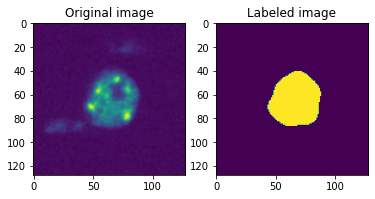

In [19]:
images = os.listdir('tiff_files')
for image in images :
    label   = imread(f"tiff_files/{image}")
    image   = image[:-4] + '_0000.tif'
    img     = imread(f"ImagesTS/{image}")
    z = img.shape[0] // 2
    y = label.shape[0] // 2
    plt.subplot(1, 2, 1)    
    plt.imshow(img[z])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(label[z])
    plt.title('Labeled image')